# **Práctica de seguimiento y flujo óptico**

Este proyecto consiste en implementar y analizar algoritmos de seguimiento de objetos en video utilizando metodologías como YOLO, Lucas-Kanade, Farneback y técnicas de Deep Learning. Se evaluará el seguimiento de una mano derecha en el video "people2", comparando los resultados mediante gráficos de posición en X, Y y velocidad, superpuestos para contrastar los algoritmos. Además, se incluirán resultados visuales aplicados a dos frames de la base de datos Flying Chairs.

### Realizado en Google Colab

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Seguimiento de una mano en el video "people2" con distintos métodos:

In [ ]:
!pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 899.0/899.0 kB 15.9 MB/s eta 0:00:00


In [ ]:
from ultralytics import YOLO
import cv2
import numpy as np

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


### Método global para calcular la velocidad

In [ ]:
def calculate_velocity(prev_position, curr_position, fps):

    if prev_position is None or curr_position is None:
        return 0.0
    distance = np.linalg.norm(np.array(curr_position) - np.array(prev_position))
    return distance * fps

En esta función se calcula la disctancia euclidiana entre el keypoint actual y el anterior, para posteriormente multiplicar ese valor por los FPS (Frames por segundo). Esto se hace de esta manera ya que la velocidad se calcula como espacio/tiempo. En este caso distancia entre frames dividido entre el tiempo entre frames. Por tanto el tiempo viene dado por 1/FPS. Y esto concluye en que la velocidad se calcula como la distancia entre frames multiplicada por los FPS.

### Método global para seleccionar el keypoint de la persona a seguir


In [ ]:
def detectar_persona(frame, model, keypoint_idx=10, conf_threshold=0.5):

    results = model.predict(source=frame, imgsz=1280, conf=conf_threshold, device=0, verbose=False)
    keypoints = results[0].keypoints

    if keypoints is not None and len(keypoints) > 0:
        selected_person_id = max(
            range(len(keypoints)),
            key=lambda i: keypoints[i].data.cpu().numpy()[0][keypoint_idx][2]
        )

        person_data = keypoints[selected_person_id].data.cpu().numpy()
        keypoint = person_data[0][keypoint_idx]

        if keypoint[2] > conf_threshold:
            x, y = int(keypoint[0]), int(keypoint[1])
            return np.array([x, y]), np.array([x, y])

    print("No se detectaron keypoints válidos en el primer cuadro.")
    return None, None

La función detectar_persona utiliza el modelo YOLO para detectar keypoints en una imagen y selecciona la persona con la mayor confianza en un keypoint específico (por defecto, la mano derecha con índice 10). Si el keypoint detectado supera un umbral de confianza mínimo, devuelve sus coordenadas (x, y) en formato NumPy. En caso contrario, imprime un mensaje indicando que no se encontraron keypoints válidos y devuelve None. Será utilizada para que todos los métodos sigan a la misma persona.

## 1. Seguimiento con YOLO únicamente



In [ ]:
# Variables globales para el seguimiento
selected_person_id = None
selected_person_center = None
max_distance_threshold = 50

# Listas para almacenar resultados
yolo_x_positions = []
yolo_y_positions = []
yolo_velocities = []

#Función para calcular el centro
def calculate_center(box):
    x1, y1, x2, y2 = map(int, box)
    return (int((x1 + x2) / 2), int((y1 + y2) / 2))

# Función para dibujar el keypoint
def draw_keypoint(frame, keypoints, n, fps):
    global selected_person_id, selected_person_center, yolo_x_positions, yolo_y_positions, yolo_velocities

    if keypoints is not None and selected_person_id is not None and selected_person_id < len(keypoints):
        person = keypoints[selected_person_id]
        person_data = person.data.cpu().numpy()
        keypoint = person_data[0][n]

        if keypoint[2] > 0.5:  # Confianza mínima del keypoint
            x, y = int(keypoint[0]), int(keypoint[1])
            cv2.circle(frame, (x, y), 4, (0, 255, 0), -1)

            # Almacenamos posición y calculamos velocidad
            velocity = calculate_velocity(selected_person_center, (x, y), fps)
            yolo_x_positions.append(x)
            yolo_y_positions.append(y)
            yolo_velocities.append(velocity)

            # Actualizamos el centro de la persona seleccionada
            selected_person_center = (x, y)

# Cargamos el modelo YOLO
model = YOLO('yolov8x-pose-p6.pt')

# Cargamos el video
video = cv2.VideoCapture('/content/drive/MyDrive/PIAV/Practica7/videos/people2.mp4')
fps = video.get(cv2.CAP_PROP_FPS)
status, frame = video.read()
if not status:
    print("Error al cargar el video")
    video.release()
    exit()

# Video de salida
size = (frame.shape[1], frame.shape[0])
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
video_out = cv2.VideoWriter('output_yolo_tracking.mp4', fourcc, 20.0, size)

frame_id = 0
while status:
    results = model.predict(source=frame, imgsz=1280, conf=0.5, device=0, verbose=False)

    annotated_frame = frame.copy()
    keypoints = results[0].keypoints
    boxes = results[0].boxes

    if keypoints is not None:
        # Seleccionamos la persona en el primer frame
        if frame_id == 0:
            # Seleccionamos la persona con mayor confianza en el keypoint 10
            selected_person_id = max(
                range(len(keypoints)),
                key=lambda i: keypoints[i].data.cpu().numpy()[0][10][2]  # Confianza del keypoint 10
            )
            selected_person_center = calculate_center(boxes[selected_person_id].xyxy[0].cpu().numpy())

        else:
            # Verificamos si la persona seleccionada sigue visible
            if selected_person_center is not None:
                min_distance = float('inf')
                closest_id = None

                for i, box in enumerate(boxes):
                    center = calculate_center(box.xyxy[0].cpu().numpy())
                    distance = np.linalg.norm(np.array(center) - np.array(selected_person_center))
                    if distance < min_distance:
                        min_distance = distance
                        closest_id = i

                # Actualizamos la persona seleccionada si sigue visible y dentro del umbral
                if min_distance < max_distance_threshold:
                    selected_person_id = closest_id
                    selected_person_center = calculate_center(boxes[selected_person_id].xyxy[0].cpu().numpy())
                else:
                    # Si la persona sale del plano se detiene el seguimiento
                    selected_person_id = None
                    selected_person_center = None

    # Dibujamos los puntos clave solo para la persona seleccionada
    if selected_person_id is not None:
        draw_keypoint(annotated_frame, keypoints, 10, fps)

    # Guardamos el resultado en el video de salida
    video_out.write(annotated_frame)

    # Leemos el siguiente frame
    status, frame = video.read()
    frame_id += 1

video.release()
video_out.release()

print("Posiciones X:", yolo_x_positions)
print("Posiciones Y:", yolo_y_positions)
print("Velocidades:", yolo_velocities)

print("Procesamiento completado. El video de salida se ha guardado como 'output_yolo_tracking.mp4'.")


100%|██████████| 190M/190M [00:01<00:00, 149MB/s]


Posiciones X: [967, 970, 972, 973, 974, 975, 976, 978, 978, 979, 980, 980, 983, 984, 985, 986, 987, 987, 988, 988, 989, 989, 992, 993, 994, 996, 997, 999, 1001, 1001, 1003, 1004, 1005, 1007, 1008, 1010, 1011, 1013, 1014, 1015, 1016, 1016, 1018, 1019, 1020, 1020, 1021, 1024, 1025, 1027, 1028, 1029, 1031, 1032, 1033, 1034, 1035, 1039, 1041, 1042, 1044, 1045, 1047, 1048, 1049, 1050, 1050, 1053, 1055, 1057, 1059, 1061, 1064, 1066, 1067, 1070, 1070, 1074, 1076, 1078, 1079, 1081, 1086, 1088, 1089, 1091, 1092, 1095, 1096, 1098, 1100, 1101, 1103, 1106, 1108, 1110, 1112, 1117, 1117, 1119, 1120, 1122, 1126, 1128, 1130, 1134, 1136, 1140, 1141, 1142, 1144, 1145, 1149, 1149, 1150, 1155, 1156, 1161, 1163, 1165, 1169, 1170, 1174, 1177, 1181, 1182, 1185, 1192, 1196, 1197, 1200, 1202, 1207, 1207, 1211, 1216]
Posiciones Y: [258, 261, 261, 261, 263, 265, 266, 269, 272, 274, 276, 277, 281, 281, 283, 283, 285, 288, 291, 293, 296, 297, 303, 305, 307, 309, 309, 312, 313, 316, 318, 322, 327, 330, 332, 334, 33

El código implementado utiliza el modelo YOLOv8 pose para detectar la posición de la mano derecha (keypoint 10) en el video. La lógica comienza con la carga del modelo preentrenado mediante la librería YOLO. A continuación, el video es procesado frame a frame dentro de un bucle, donde se utiliza la función `predict` del modelo para identificar los keypoints de las personas (puntos clave del cuerpo). En el primer frame, se selecciona la persona con mayor confianza en el keypoint 10, correspondiente a la mano derecha, mediante una búsqueda del valor máximo dentro del array de keypoints. Para ello, se comparan las confianzas de todas las personas detectadas usando la función `max` con un criterio definido por la confianza del punto clave. De esta manera nos aseguramos de seguir a la persona que tiene la mano derecha más visible. Este método de selección será el utilizado en todos los siguientes métodos para así trackear a la misma persona y poder realizar la comparación de resultados.

Una vez seleccionada la persona objetivo, en cada frame subsiguiente se extraen las coordenadas del keypoint 10 si su confianza supera un umbral predefinido (0.5), lo que garantiza que solo se consideran predicciones fiables. Estas coordenadas se almacenan en una variable y se utilizan para calcular la posición actual de la mano. Finalmente, la posición y velocidad calculadas se almacenan en listas para su posterior análisis.

## 2. Seguimiento con Lukas Kanade implementado manualmente

In [ ]:
# Variables globales para el seguimiento
selected_person_id = None
selected_keypoint_position = None
prev_keypoint_position = None
person_out_of_frame = False
max_distance_threshold = 50

# Listas para almacenar resultados
lk_x_positions = []
lk_y_positions = []
lk_velocities = []

# Método de Lucas-Kanade manual
def manual_lucas_kanade(prev_frame, curr_frame, prev_point, window_size=31):

    dx = cv2.Sobel(prev_frame, cv2.CV_64F, 1, 0, ksize=3)
    dy = cv2.Sobel(prev_frame, cv2.CV_64F, 0, 1, ksize=3)
    dt = curr_frame.astype(np.float64) - prev_frame.astype(np.float64)

    x, y = map(int, prev_point)
    half = window_size // 2

    try:
        window_dx = dx[y-half:y+half+1, x-half:x+half+1]
        window_dy = dy[y-half:y+half+1, x-half:x+half+1]
        window_dt = dt[y-half:y+half+1, x-half:x+half+1]

        dx_flat = window_dx.flatten()
        dy_flat = window_dy.flatten()
        dt_flat = window_dt.flatten()

        A = np.column_stack([dx_flat, dy_flat])
        b = -dt_flat

        ATA = A.T @ A
        epsilon = 1e-8
        ATA += epsilon * np.eye(ATA.shape[0])
        flow = np.linalg.inv(ATA) @ A.T @ b

        new_x = x + flow[0]
        new_y = y + flow[1]

        return np.array([new_x, new_y])
    except Exception as e:
        print(f"Error en Lucas-Kanade manual: {e}")
        return prev_point

# Cargamos modelo YOLO
model = YOLO('yolov8x-pose-p6.pt')

# Cargamos video
video = cv2.VideoCapture('/content/drive/MyDrive/PIAV/Practica7/videos/people2.mp4')
fps = video.get(cv2.CAP_PROP_FPS)
status, prev_frame = video.read()

if not status:
    print("Error al cargar el video")
    video.release()
    exit()

prev_gray = cv2.cvtColor(prev_frame, cv2.COLOR_BGR2GRAY)

# Detectamos persona en el primer frame
selected_keypoint_position, prev_keypoint_position = detectar_persona(prev_frame, model)

if selected_keypoint_position is None:
    video.release()
    exit()

# Configuramos video de salida
size = (prev_frame.shape[1], prev_frame.shape[0])
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
video_out = cv2.VideoWriter('output_lk_tracking.mp4', fourcc, 20.0, size)

frame_id = 0
status, curr_frame = video.read()

while status:
    copy = curr_frame.copy()

    # Actualización de posición con Lucas-Kanade
    if selected_keypoint_position is not None:
        curr_gray = cv2.cvtColor(curr_frame, cv2.COLOR_BGR2GRAY)
        next_position = manual_lucas_kanade(prev_gray, curr_gray, selected_keypoint_position)

        if np.linalg.norm(next_position - selected_keypoint_position) < max_distance_threshold:
            prev_keypoint_position = selected_keypoint_position
            selected_keypoint_position = next_position

            # Dibujar keypoint y almacenar resultados
            cv2.circle(copy, (int(next_position[0]), int(next_position[1])), 4, (255, 0, 0), -1)
            velocity = calculate_velocity(prev_keypoint_position, next_position, fps)
            lk_x_positions.append(next_position[0])
            lk_y_positions.append(next_position[1])
            lk_velocities.append(velocity)
        else:
            print("La persona seleccionada salió del plano.")
            person_out_of_frame = True
            selected_keypoint_position = None

    # Actualización del frame
    video_out.write(copy)
    prev_gray = cv2.cvtColor(curr_frame, cv2.COLOR_BGR2GRAY)
    prev_frame = curr_frame.copy()
    status, curr_frame = video.read()
    frame_id += 1

video.release()
video_out.release()

print("Posiciones X:", lk_x_positions)
print("Posiciones Y:", lk_y_positions)
print("Velocidades:", lk_velocities)
print("El video con seguimiento se ha guardado como 'output_lk_tracking.mp4'.")


Posiciones X: [967.1276928702553, 967.1110011781177, 967.0980407573034, 967.1162699087902, 967.1043356147949, 967.1105090453256, 967.1173781501641, 967.085955192766, 967.1017520825089, 967.1207797126324, 967.1217659226455, 967.1386804187899, 967.1298043268558, 967.1079421342444, 966.9719758457431, 965.9859249557329, 964.9793034628137, 963.9195615389913, 962.9680849067043, 961.999135567277, 960.9938175857375, 959.9399981012134, 958.9840587977071, 957.9988422188745, 956.9708754107081, 956.0, 955.9633766206704, 954.999927023549, 953.9984098937425, 953.0000356490142, 952.999742037258, 951.999899277071, 951.0000330112521, 951.0212566821928, 951.0047044595916, 951.0036983156423, 950.992936481973, 950.015872637281, 949.9985150319626, 949.0112931125399, 948.9982593079319, 948.00071436342, 948.0029760573631, 948.0052265942561, 948.0027524642992, 948.0023007609027, 947.9999087813663, 946.9979828417617, 946.0, 946.0088792811487, 945.9962286860803, 945.0088744850931, 944.9946749109614, 944.0115911

El código de Lucas-Kanade implementado manualmente se utiliza para rastrear el keypoint detectado previamente con YOLO en el primer frame del video. La lógica de este código es muy similar al anterior, pero en este caso YOLO solo se utiliza para detectar el primer keypoint a seguir (hecho de la misma forma que en el anterior código). Luego, el método `manual_lucas_kanade()` es el encargado de realizar el tracking del keypoint. Se basa en calcular los gradientes espaciales y temporales alrededor del punto clave detectado, extrayendo una ventana local para construir un sistema lineal que relaciona los cambios de intensidad con el desplazamiento del keypoint. Para realizarlo, nos basamos en el artículo leído en clase sobre Lucas Kanade, a continuación se explica más en profundidad.

### Explicación del Algoritmo de Lucas-Kanade Implementado Manualmente

El algoritmo implementado sigue el método descrito por Lucas y Kanade (1981), método que se explica en el artículo facilitado en el campus de la asignatura. Se basa en la estimación del flujo óptico local mediante gradientes espaciales y temporales. A continuación, se explica brevemente el proceso en el que se fundamenta el método `manual_lucas_kanade()` utilizado en el código:

1. **Cálculo de Gradientes**:
   - $ \frac{\partial I}{\partial x}, \frac{\partial I}{\partial y} $: Gradientes espaciales calculados con el operador Sobel, como se menciona en la ecuación (9) del artículo.
   - $ \frac{\partial I}{\partial t} $: Gradiente temporal calculado como la diferencia entre los cuadros consecutivos.

2. **Ventana Local**:
   - Se extraen valores de gradientes en una ventana alrededor del punto a rastrear. Este enfoque sigue lo descrito en la Sección 4.2 del artículo, donde el cálculo se limita a regiones locales para minimizar errores.

3. **Resolución del Sistema**:
   - Se construye la matriz $ A $ (gradientes espaciales) y el vector $ b $ (gradientes temporales negativos):
     
  $$ A =
  \begin{bmatrix}
      \frac{\partial I}{\partial x} & \frac{\partial I}{\partial y} \\
      \vdots & \vdots
  \end{bmatrix}
  $$

  $$ b = -
  \begin{bmatrix}
      \frac{\partial I}{\partial t} \\
      \vdots
  \end{bmatrix}
  $$


   - El desplazamiento $ \vec{v} = (u, v) $ se calcula minimizando $ ||A\vec{v} - b||^2 $, como se describe en la ecuación (10) del artículo:
  
    $$  \vec{v} = (A^T A + \epsilon I)^{-1} A^T b $$
     

4. **Actualización del Punto**:
   - El punto rastreado se actualiza según el desplazamiento calculado:

     $$ \text{new\_x} = x + u, \quad \text{new\_y} = y + v $$

Este método, fundamentado en la aproximación local, es robusto en ventanas pequeñas con gradientes definidos, como se explica en las Secciones 4.2 y 4.3 del artículo facilitado en clase.



## 3. Segumiento con Lucas Kanade usando el método de opencv

In [ ]:
# Variables globales en el seguimiento
selected_person_id = None
selected_keypoint_position = None
prev_keypoint_position = None
person_out_of_frame = False
max_distance_threshold = 50

# Parámetros para Lucas-Kanade
lk_params = dict(winSize=(15, 15), maxLevel=2,
                 criteria=(cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 10, 0.03))

# Listas para almacenar resultados
lk_cv_x_positions = []
lk_cv_y_positions = []
lk_cv_velocities = []

# Cargamos el modelo YOLO
model = YOLO('yolov8x-pose-p6.pt')

# Cargamos el video
video = cv2.VideoCapture('/content/drive/MyDrive/PIAV/Practica7/videos/people2.mp4')
fps = video.get(cv2.CAP_PROP_FPS)
status, prev_frame = video.read()

if not status:
    print("Error al cargar el video")
    video.release()
    exit()

prev_gray = cv2.cvtColor(prev_frame, cv2.COLOR_BGR2GRAY)

# Detectamos la persona inicial y su keypoint
selected_keypoint_position, prev_keypoint_position = detectar_persona(prev_frame, model)

# Convertir a 2D (formato [[x, y]]) para que sea compatible con la función de opencv
if selected_keypoint_position is not None:
    selected_keypoint_position = np.array([[selected_keypoint_position[0], selected_keypoint_position[1]]], dtype=np.float32)
    prev_keypoint_position = np.array([[prev_keypoint_position[0], prev_keypoint_position[1]]], dtype=np.float32)
else:
    print("No se detectó ninguna persona válida en el primer cuadro.")
    video.release()
    exit()

# Video de salida
size = (prev_frame.shape[1], prev_frame.shape[0])
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
video_out = cv2.VideoWriter('output_opencv_lk_tracking.mp4', fourcc, 20.0, size)

frame_id = 0
while status:
    # Procesamos si el keypoint fue detectado inicialmente
    if selected_keypoint_position is not None:
        x, y = int(selected_keypoint_position[0][0]), int(selected_keypoint_position[0][1])
        h, w = prev_frame.shape[:2]
        if 0 <= x < w and 0 <= y < h:
            cv2.circle(prev_frame, (x, y), 4, (0, 255, 0), -1)

            # Calculamos velocidad y almacenamos resultados
            velocity = calculate_velocity(prev_keypoint_position[0], (x, y), fps)
            lk_cv_x_positions.append(x)
            lk_cv_y_positions.append(y)
            lk_cv_velocities.append(velocity)
        else:
            print(f"Keypoint fuera del marco en frame {frame_id}: x={x}, y={y}")
            person_out_of_frame = True
            selected_keypoint_position = None
            continue

    status, curr_frame = video.read()
    if not status:
        break

    curr_gray = cv2.cvtColor(curr_frame, cv2.COLOR_BGR2GRAY)

    # Actualizamos la posición del keypoint usando Lucas-Kanade
    if selected_keypoint_position is not None:
        next_keypoint_position, status_lk, _ = cv2.calcOpticalFlowPyrLK(
            prev_gray, curr_gray, selected_keypoint_position, None, **lk_params)

        if status_lk[0][0] == 1:
            x, y = next_keypoint_position[0].ravel()
            if 0 <= x < curr_frame.shape[1] and 0 <= y < curr_frame.shape[0]:
                prev_keypoint_position = selected_keypoint_position.copy()
                selected_keypoint_position = np.array([[x, y]], dtype=np.float32)
                cv2.circle(curr_frame, (int(x), int(y)), 4, (0, 255, 0), -1)
            else:
                print(f"Keypoint fuera del marco en frame {frame_id}: x={x}, y={y}")
                person_out_of_frame = True
                selected_keypoint_position = None

    # Actualización del frame
    video_out.write(curr_frame)
    prev_gray = curr_gray.copy()
    prev_frame = curr_frame.copy()
    frame_id += 1

video.release()
video_out.release()

print("Posiciones X:", lk_cv_x_positions)
print("Posiciones Y:", lk_cv_y_positions)
print("Velocidades:", lk_cv_velocities)
print("Procesamiento completado. El video con seguimiento del keypoint se ha guardado como 'output_opencv_lk_tracking.mp4'.")


Keypoint fuera del marco en frame 137: x=1221.490966796875, y=721.0789794921875
Posiciones X: [967, 969, 970, 971, 972, 973, 974, 975, 976, 977, 978, 978, 981, 982, 983, 984, 985, 986, 986, 987, 987, 988, 990, 991, 992, 994, 995, 997, 998, 999, 1000, 1001, 1003, 1004, 1006, 1007, 1009, 1011, 1013, 1013, 1014, 1015, 1017, 1017, 1019, 1020, 1021, 1023, 1024, 1025, 1026, 1027, 1029, 1030, 1031, 1032, 1033, 1036, 1038, 1040, 1042, 1043, 1046, 1046, 1047, 1048, 1050, 1052, 1054, 1056, 1058, 1059, 1063, 1064, 1066, 1067, 1069, 1072, 1073, 1075, 1077, 1080, 1084, 1086, 1088, 1090, 1091, 1094, 1095, 1096, 1098, 1099, 1103, 1105, 1107, 1109, 1111, 1114, 1115, 1117, 1119, 1120, 1124, 1127, 1129, 1132, 1135, 1138, 1140, 1141, 1142, 1143, 1147, 1148, 1150, 1153, 1155, 1159, 1162, 1164, 1166, 1168, 1172, 1175, 1177, 1181, 1184, 1191, 1194, 1196, 1198, 1200, 1205, 1207, 1207, 1210, 1210, 1217]
Posiciones Y: [258, 260, 261, 262, 263, 264, 266, 269, 272, 274, 276, 278, 281, 282, 283, 284, 285, 288, 29

El código que implementa Lucas-Kanade utilizando la función de OpenCV (`cv2.calcOpticalFlowPyrLK`) realiza el seguimiento del keypoint detectado por YOLO de manera más eficiente y directa que la implementación manual. Este método calcula el flujo óptico para un conjunto de puntos clave entre dos cuadros consecutivos mediante el uso de la pirámide de imágenes, que permite trabajar en múltiples escalas para mejorar la precisión y robustez del cálculo.

La lógica del código consiste en pasar la posición del keypoint detectado previamente junto con los cuadros anteriores y actuales a la función `cv2.calcOpticalFlowPyrLK`. Esta función devuelve la nueva posición del keypoint en el cuadro actual, así como un indicador de la validez del cálculo. Si el cálculo es válido, se actualizan las coordenadas del keypoint, y estas se almacenan para calcular su velocidad y visualizar su posición en el video. El uso de OpenCV simplifica considerablemente el proceso al abstraer los cálculos matemáticos del método, haciendo el seguimiento más eficiente y menos propenso a errores.


## 4. Segumiento con Farneback

In [ ]:
# Variables globales en el seguimiento
selected_person_id = None
selected_keypoint_position = None
prev_keypoint_position = None
person_out_of_frame = False
max_distance_threshold = 50

# Listas para almacenar resultados
fb_x_positions = []
fb_y_positions = []
fb_velocities = []

# Cargamos modelo YOLO
model = YOLO('yolov8x-pose-p6.pt')

# Cargamos el video
video = cv2.VideoCapture('/content/drive/MyDrive/PIAV/Practica7/videos/people2.mp4')
fps = video.get(cv2.CAP_PROP_FPS)
status, prev_frame = video.read()

if not status:
    print("Error al cargar el video")
    video.release()
    exit()

prev_gray = cv2.cvtColor(prev_frame, cv2.COLOR_BGR2GRAY)

# Detectamos la persona inicial y su keypoint
selected_keypoint_position, prev_keypoint_position = detectar_persona(prev_frame, model)

# Convertir a 2D (formato [[x, y]]) para que sea compatible con la función de opencv
if selected_keypoint_position is not None:
    selected_keypoint_position = np.array([selected_keypoint_position[0], selected_keypoint_position[1]])
    prev_keypoint_position = np.array([prev_keypoint_position[0], prev_keypoint_position[1]])
else:
    print("No se detectaron keypoints en el primer cuadro.")
    video.release()
    exit()

# Video de salida
size = (prev_frame.shape[1], prev_frame.shape[0])
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
video_out = cv2.VideoWriter('output_farneback_tracking.mp4', fourcc, 20.0, size)

frame_id = 0
while status:
    # Procesamos solo si el keypoint inicial ha sido detectado
    if selected_keypoint_position is not None:
        x, y = int(selected_keypoint_position[0]), int(selected_keypoint_position[1])
        cv2.circle(prev_frame, (x, y), 4, (0, 255, 0), -1)

        # Calculamos velocidad y almacenamos la posición
        velocity = calculate_velocity(prev_keypoint_position, (x, y), fps)
        fb_x_positions.append(x)
        fb_y_positions.append(y)
        fb_velocities.append(velocity)

    status, curr_frame = video.read()
    if not status:
        break

    curr_gray = cv2.cvtColor(curr_frame, cv2.COLOR_BGR2GRAY)

    # Actualizamos la posición del keypoint usando Farneback
    if selected_keypoint_position is not None:
        flow = cv2.calcOpticalFlowFarneback(prev_gray, curr_gray, None, 0.5, 3, 15, 3, 5, 1.2, 0)
        h, w = flow.shape[:2]
        x, y = int(selected_keypoint_position[0]), int(selected_keypoint_position[1])

        if 0 <= x < w and 0 <= y < h:
            dx, dy = flow[y, x]
            new_x = selected_keypoint_position[0] + dx
            new_y = selected_keypoint_position[1] + dy
            prev_keypoint_position = selected_keypoint_position
            selected_keypoint_position = np.array([new_x, new_y])

            cv2.circle(curr_frame, (int(new_x), int(new_y)), 4, (255, 0, 0), -1)
        else:
            print(f"Keypoint fuera de los límites: x={x}, y={y}")
            person_out_of_frame = True
            selected_keypoint_position = None

    video_out.write(curr_frame)
    prev_gray = curr_gray.copy()
    prev_frame = curr_frame.copy()
    frame_id += 1

video.release()
video_out.release()

print("Posiciones X:", fb_x_positions)
print("Posiciones Y:", fb_y_positions)
print("Velocidades:", fb_velocities)
print("Procesamiento completado. El video con seguimiento del keypoint se ha guardado como 'output_farneback_tracking.mp4'.")

Keypoint fuera de los límites: x=1213, y=721
Posiciones X: [967, 969, 970, 971, 972, 973, 974, 975, 976, 977, 977, 978, 981, 982, 983, 984, 985, 985, 986, 986, 987, 988, 990, 991, 992, 994, 995, 997, 998, 999, 1000, 1001, 1003, 1004, 1006, 1007, 1009, 1011, 1012, 1013, 1014, 1015, 1016, 1017, 1018, 1019, 1021, 1023, 1024, 1025, 1026, 1027, 1029, 1030, 1031, 1032, 1033, 1036, 1038, 1040, 1042, 1043, 1045, 1046, 1047, 1048, 1050, 1053, 1054, 1056, 1058, 1059, 1063, 1064, 1066, 1067, 1069, 1072, 1073, 1075, 1077, 1080, 1084, 1086, 1088, 1089, 1091, 1093, 1095, 1096, 1098, 1099, 1103, 1105, 1107, 1109, 1110, 1114, 1115, 1117, 1118, 1120, 1124, 1127, 1129, 1132, 1134, 1138, 1139, 1141, 1142, 1143, 1147, 1149, 1150, 1153, 1155, 1159, 1162, 1164, 1166, 1168, 1172, 1174, 1177, 1180, 1184, 1190, 1193, 1195, 1198, 1200, 1204, 1207, 1210, 1213]
Posiciones Y: [258, 260, 261, 262, 263, 264, 266, 270, 272, 274, 276, 278, 281, 282, 283, 284, 285, 288, 291, 293, 296, 298, 303, 305, 306, 307, 309, 312,

El código que utiliza el método de Farneback para calcular el flujo óptico genera un campo de movimiento denso entre dos cuadros consecutivos, en lugar de rastrear puntos clave específicos. Este enfoque calcula el flujo óptico en cada píxel utilizando aproximaciones polinomiales para modelar los cambios de intensidad.

En este caso, el flujo óptico denso se evalúa específicamente en las coordenadas del keypoint detectado previamente con YOLO. Se utiliza la función `cv2.calcOpticalFlowFarneback`, que toma los cuadros anteriores y actuales, y devuelve las componentes del desplazamiento (dx, dy) en cada píxel. Estas componentes se aplican a la posición previa del keypoint para actualizar su ubicación en el cuadro actual. El método de Farneback proporciona una estimación precisa del movimiento incluso en regiones sin puntos clave específicos, complementando la detección inicial con YOLO.


## 5. Segumiento con Deep Learning usando RAFT

In [ ]:
import torch
from torchvision.models.optical_flow import raft_large, Raft_Large_Weights
from torchvision.transforms import functional as F

# Variables globales para el seguimiento
selected_person_id = None
selected_keypoint_position = None
prev_keypoint_position = None
person_out_of_frame = False
max_distance_threshold = 50

# Listas para almacenar resultados
raft_x_positions = []
raft_y_positions = []
raft_velocities = []

# Cargamos el modelo RAFT
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
raft_model = raft_large(weights=Raft_Large_Weights.DEFAULT).to(device).eval()


# Carga,os el modelo YOLO
model = YOLO('yolov8x-pose-p6.pt')

# Cargamos el video
video = cv2.VideoCapture('/content/drive/MyDrive/PIAV/Practica7/videos/people2.mp4')
fps = video.get(cv2.CAP_PROP_FPS)
status, prev_frame = video.read()

if not status:
    print("Error al cargar el video")
    video.release()
    exit()

size = (prev_frame.shape[1], prev_frame.shape[0])
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
video_out = cv2.VideoWriter('output_raft_tracking.mp4', fourcc, 20.0, size)

frame_id = 0
prev_tensor = F.to_tensor(prev_frame).unsqueeze(0).to(device)

while status:
    if not person_out_of_frame:
        results = model.predict(source=prev_frame, imgsz=1280, conf=0.5, device=0, verbose=False)
        keypoints = results[0].keypoints
        boxes = results[0].boxes

        if keypoints is not None and len(keypoints) > 0:
            if frame_id == 0:
                # Seleccionamos la persona con mayor confianza en el keypoint 10
                selected_person_id = max(
                    range(len(keypoints)),
                    key=lambda i: keypoints[i].data.cpu().numpy()[0][10][2]
                )
            else:
                if selected_person_id is not None and selected_keypoint_position is not None:
                    min_distance = float('inf')
                    closest_id = None

                    for i, box in enumerate(boxes):
                        box_coords = box.xyxy[0].cpu().numpy()
                        center = ((box_coords[0] + box_coords[2]) / 2, (box_coords[1] + box_coords[3]) / 2)
                        distance = np.linalg.norm(np.array(center) - np.array(selected_keypoint_position))
                        if distance < min_distance:
                            min_distance = distance
                            closest_id = i

                    if closest_id is not None and min_distance < max_distance_threshold:
                        selected_person_id = closest_id
                    else:
                        person_out_of_frame = True
                        selected_keypoint_position = None
                        print("La persona seleccionada salió del plano. Deteniendo seguimiento.")

    # Procesamos solo el keypoint 10 (mano derecha) de la persona seleccionada
    if keypoints is not None and selected_person_id is not None and selected_person_id < len(keypoints) and not person_out_of_frame:
        person = keypoints[selected_person_id]
        person_data = person.data.cpu().numpy()
        keypoint = person_data[0][10]

        if keypoint[2] > 0.5:
            x, y = int(keypoint[0]), int(keypoint[1])
            prev_keypoint_position = selected_keypoint_position
            selected_keypoint_position = np.array([x, y], dtype=np.float32)

            cv2.circle(prev_frame, (x, y), 4, (0, 255, 0), -1)

            velocity = calculate_velocity(prev_keypoint_position, (x, y), fps)
            raft_x_positions.append(x)
            raft_y_positions.append(y)
            raft_velocities.append(velocity)

    status, curr_frame = video.read()
    if not status:
        break

    curr_tensor = F.to_tensor(curr_frame).unsqueeze(0).to(device)

    # Calculamos flujo óptico con RAFT
    if selected_keypoint_position is not None:
        with torch.no_grad():
            flow = raft_model(prev_tensor, curr_tensor)[-1]
            flow_numpy = flow.squeeze(0).permute(1, 2, 0).cpu().numpy()
            flow_x, flow_y = flow_numpy[int(selected_keypoint_position[1]), int(selected_keypoint_position[0])]

            # Actualizamos la posición del keypoint
            x = selected_keypoint_position[0] + flow_x
            y = selected_keypoint_position[1] + flow_y
            prev_keypoint_position = selected_keypoint_position
            selected_keypoint_position = np.array([x, y], dtype=np.float32)
            cv2.circle(curr_frame, (int(x), int(y)), 4, (0, 255, 0), -1)

    video_out.write(curr_frame)
    prev_tensor = curr_tensor
    prev_frame = curr_frame.copy()
    frame_id += 1

video.release()
video_out.release()

print("Posiciones X:", raft_x_positions)
print("Posiciones Y:", raft_y_positions)
print("Velocidades:", raft_velocities)
print("Procesamiento completado. El video con seguimiento del keypoint se ha guardado como 'output_raft_tracking.mp4'.")

Downloading: "https://download.pytorch.org/models/raft_large_C_T_SKHT_V2-ff5fadd5.pth" to /root/.cache/torch/hub/checkpoints/raft_large_C_T_SKHT_V2-ff5fadd5.pth
100%|██████████| 20.1M/20.1M [00:00<00:00, 84.8MB/s]


La persona seleccionada salió del plano. Deteniendo seguimiento.
Posiciones X: [967, 970, 971, 972, 973, 974, 975, 976, 977, 978, 979, 979, 982, 984, 984, 984, 985, 986, 987, 988, 989, 989, 992, 993, 994, 995, 996, 998, 999, 1000, 1001, 1003, 1005, 1006, 1007, 1009, 1010, 1013, 1014, 1015, 1015, 1016, 1018, 1019, 1020, 1021, 1022, 1024, 1025, 1027, 1028, 1029, 1031, 1031, 1032, 1033, 1034, 1039, 1041, 1042, 1044, 1045, 1047, 1048, 1049, 1050, 1051, 1054, 1057, 1058, 1060, 1061, 1064, 1066, 1067, 1071, 1070, 1073, 1076, 1078, 1080, 1081, 1086, 1089, 1090, 1091, 1092, 1095, 1096, 1099, 1101, 1102, 1104, 1106, 1109, 1110, 1112, 1116, 1117, 1118, 1119, 1121, 1126, 1128, 1131, 1134, 1137, 1141, 1142, 1142, 1144, 1146, 1149, 1150, 1152, 1156, 1157, 1161, 1164, 1165, 1168, 1171, 1175, 1177, 1180, 1184, 1188, 1191, 1196, 1199, 1200, 1202, 1208, 1211, 1215, 1217]
Posiciones Y: [258, 258, 258, 258, 258, 262, 263, 266, 268, 270, 272, 273, 275, 274, 276, 276, 279, 285, 287, 289, 292, 294, 299, 302

El código que utiliza RAFT aplica un modelo avanzado de flujo óptico basado en redes neuronales profundas para calcular el desplazamiento entre dos cuadros consecutivos. A diferencia de los métodos tradicionales como Lucas-Kanade o Farneback, RAFT no se limita a cálculos locales. En su lugar, evalúa pares de puntos en toda la imagen y refina iterativamente las estimaciones del movimiento.

Los cuadros del video son convertidos a tensores y procesados por el modelo preentrenado RAFT, que devuelve un mapa denso de desplazamientos. En este mapa, se extrae específicamente el flujo correspondiente a las coordenadas del keypoint detectado por YOLO. Estas componentes se utilizan para actualizar la posición del keypoint en el cuadro actual, siguiendo los desplazamientos estimados. RAFT destaca por su capacidad para manejar movimientos complejos y obtener resultados consistentes, integrando el análisis global del movimiento con precisión local.

Probamos varias estrategias para que RAFT funcionara de forma independiente, así como el uso de Deep SORT para el seguimiento de objetos. Sin embargo, debido a los desafíos encontrados en estabilidad y rendimiento, decidimos utilizar YOLO como respaldo para seleccionar y validar el keypoint objetivo, permitiendo que RAFT actúe principalmente en la actualización de la posición en base al flujo óptico.


## Gráficas comparativas entre los distintos métodos:

In [ ]:
import matplotlib.pyplot as plt

## 1. Gráfica de posición en X de la mano

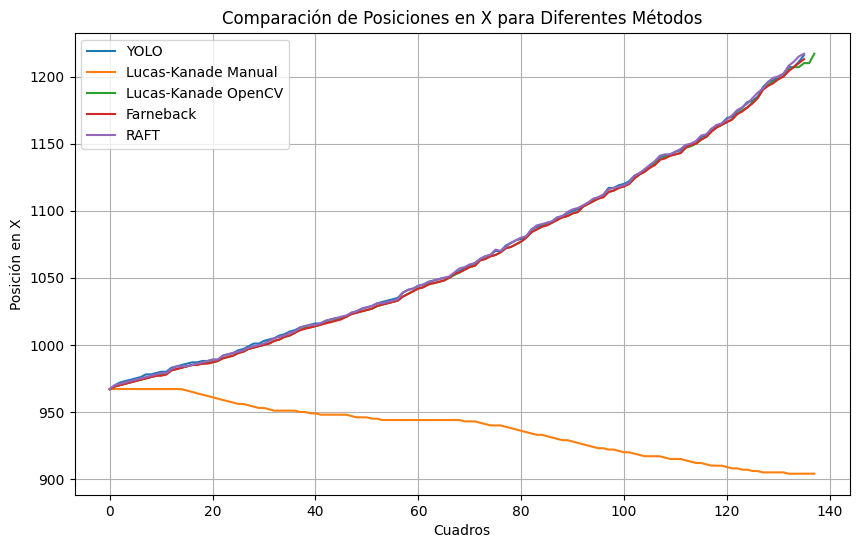

In [ ]:
"Posiciones en X"

max_length = max(len(yolo_x_positions), len(lk_cv_x_positions), len(fb_x_positions), len(raft_x_positions))
lk_x_positions_trunc = lk_x_positions[:max_length]

plt.figure(figsize=(10, 6))
plt.plot(yolo_x_positions, label="YOLO", marker='')
plt.plot(lk_x_positions_trunc, label="Lucas-Kanade Manual", marker='')
plt.plot(lk_cv_x_positions, label="Lucas-Kanade OpenCV", marker='')
plt.plot(fb_x_positions, label="Farneback", marker='')
plt.plot(raft_x_positions, label="RAFT", marker='')

plt.xlabel("Cuadros")
plt.ylabel("Posición en X")
plt.title("Comparación de Posiciones en X para Diferentes Métodos")
plt.legend()
plt.grid(True)
plt.show()


## 2. Gráfica de posición en Y de la mano

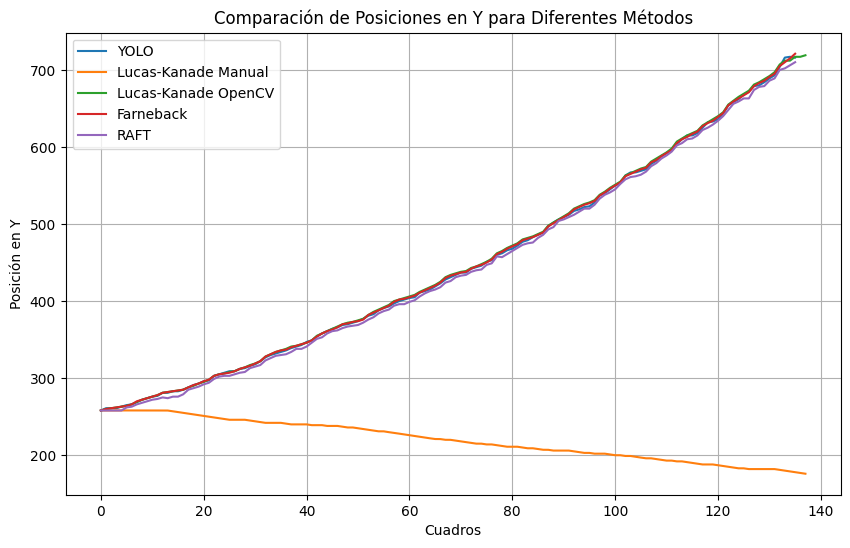

In [ ]:
"Posiciones en Y"

max_length = max(len(yolo_y_positions), len(lk_cv_y_positions), len(fb_y_positions), len(raft_y_positions))
lk_y_positions_trunc = lk_y_positions[:max_length]

plt.figure(figsize=(10, 6))
plt.plot(yolo_y_positions, label="YOLO", marker='')
plt.plot(lk_y_positions_trunc, label="Lucas-Kanade Manual", marker='')
plt.plot(lk_cv_y_positions, label="Lucas-Kanade OpenCV", marker='')
plt.plot(fb_y_positions, label="Farneback", marker='')
plt.plot(raft_y_positions, label="RAFT", marker='')

plt.xlabel("Cuadros")
plt.ylabel("Posición en Y")
plt.title("Comparación de Posiciones en Y para Diferentes Métodos")
plt.legend()
plt.grid(True)
plt.show()


## 3. Gráfica de velocidad de la mano

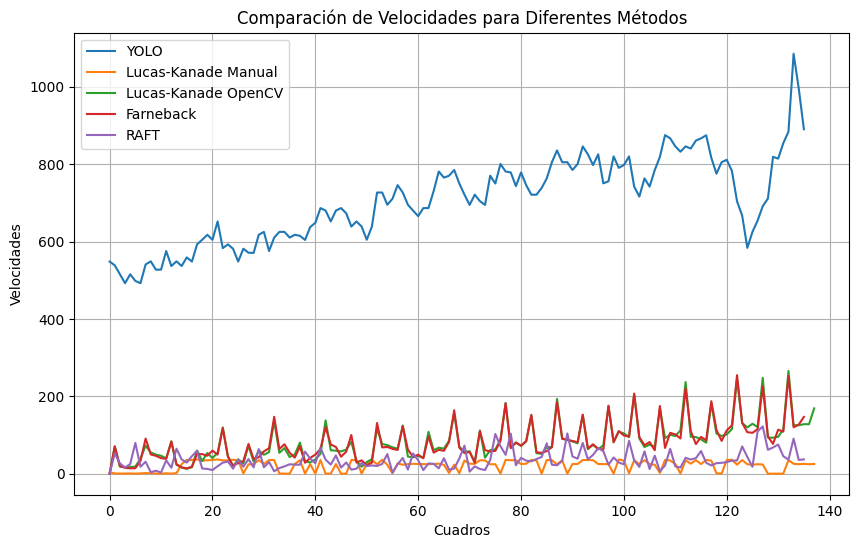

In [ ]:
"Velocidad"

max_length = max(len(yolo_velocities), len(lk_cv_velocities), len(fb_velocities), len(raft_velocities))
lk_velocities_trunc = lk_velocities[:max_length]

plt.figure(figsize=(10, 6))
plt.plot(yolo_velocities, label="YOLO", marker='')
plt.plot(lk_velocities_trunc, label="Lucas-Kanade Manual", marker='')
plt.plot(lk_cv_velocities, label="Lucas-Kanade OpenCV", marker='')
plt.plot(fb_velocities, label="Farneback", marker='')
plt.plot(raft_velocities, label="RAFT", marker='')

plt.xlabel("Cuadros")
plt.ylabel("Velocidades")
plt.title("Comparación de Velocidades para Diferentes Métodos")
plt.legend()
plt.grid(True)
plt.show()


# Comparativa de frames con la base de datos *Chairs*

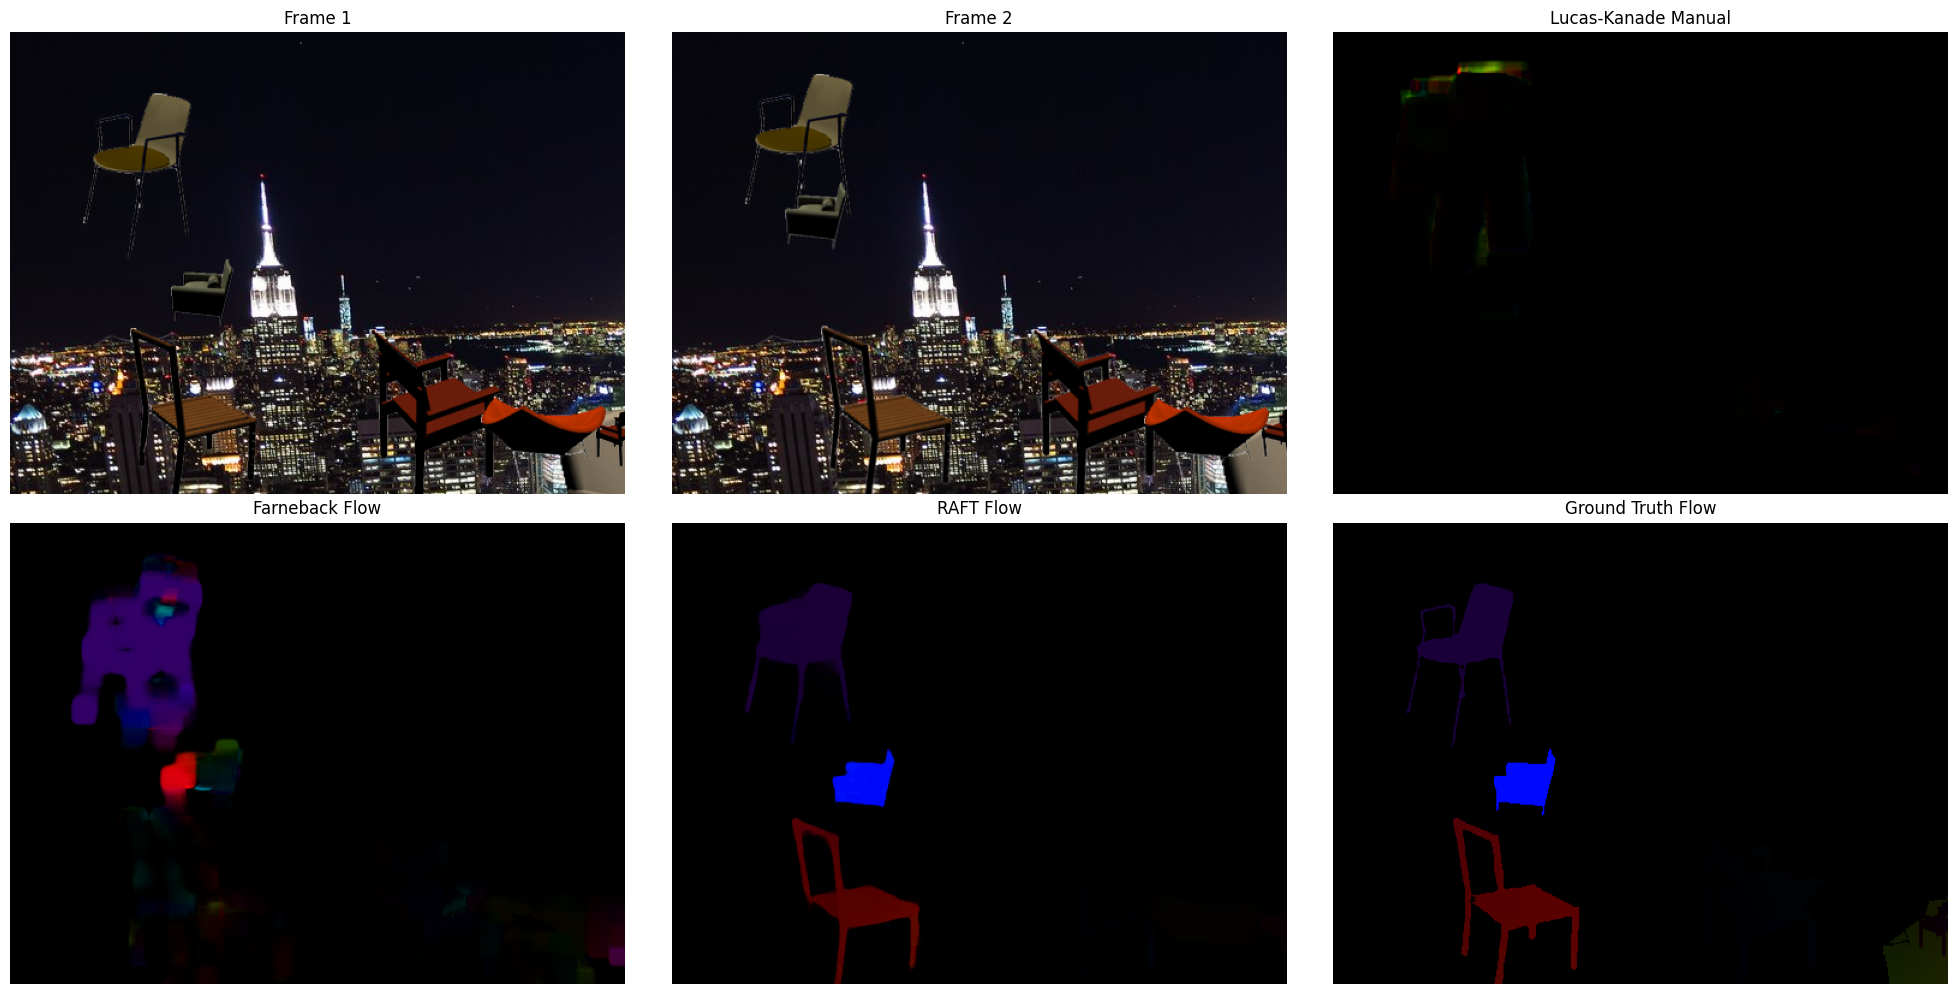

In [ ]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from torchvision.models.optical_flow import raft_large
from torchvision.transforms.functional import to_tensor
import torch

device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Función para leer archivos .flo
def read_flo_file(file_path):
    with open(file_path, 'rb') as f:
        magic = np.fromfile(f, dtype=np.float32, count=1)[0]
        if magic != 202021.25:
            raise ValueError("Formato inválido en archivo .flo")

        width = np.fromfile(f, dtype=np.int32, count=1)[0]
        height = np.fromfile(f, dtype=np.int32, count=1)[0]

        flow_data = np.fromfile(f, dtype=np.float32, count=2 * width * height)
        flow = np.resize(flow_data, (height, width, 2))
        return flow

# Lucas-Kanade Manual
def lucas_kanade_manual(I1, I2, window_size=31, iterations=10):

    Ix = cv2.Sobel(I1, cv2.CV_64F, 1, 0, ksize=5)
    Iy = cv2.Sobel(I1, cv2.CV_64F, 0, 1, ksize=5)
    It = I2 - I1

    flow = np.zeros((I1.shape[0], I1.shape[1], 2), dtype=np.float32)
    half_window = window_size // 2

    for y in range(half_window, I1.shape[0] - half_window):
        for x in range(half_window, I1.shape[1] - half_window):
            Ix_window = Ix[y - half_window:y + half_window + 1, x - half_window:x + half_window + 1].flatten()
            Iy_window = Iy[y - half_window:y + half_window + 1, x - half_window:x + half_window + 1].flatten()
            It_window = It[y - half_window:y + half_window + 1, x - half_window:x + half_window + 1].flatten()

            A = np.vstack((Ix_window, Iy_window)).T
            b = -It_window

            AtA = A.T @ A

            if np.linalg.det(AtA) != 0:
                h = np.linalg.inv(AtA) @ A.T @ b
                flow[y, x, :] = h

    return flow


# Definimos la carpeta donde se encuentran los archivos
data_dir = "/content/drive/MyDrive/PIAV/Practica7/FlyingChairs"

# Cargamos los frames y el flujo ground truth desde la carpeta FlyingChairs
frame1_path = os.path.join(data_dir, "00005_img1.ppm")
frame2_path = os.path.join(data_dir, "00005_img2.ppm")
ground_truth_path = os.path.join(data_dir, "00005_flow.flo")

# Leemos los datos
frame1 = cv2.imread(frame1_path)
frame2 = cv2.imread(frame2_path)
ground_truth = read_flo_file(ground_truth_path)

# Convertimos frames a escala de grises para algunos algoritmos
gray1 = cv2.cvtColor(frame1, cv2.COLOR_BGR2GRAY)
gray2 = cv2.cvtColor(frame2, cv2.COLOR_BGR2GRAY)

# 1. Lucas-Kanade Manual
flow_lk_manual = lucas_kanade_manual(gray1, gray2)

# 2. Farneback Optical Flow
flow_fb = cv2.calcOpticalFlowFarneback(gray1, gray2, None, 0.5, 5, 15, 3, 7, 1.5, 0)

# 3. RAFT Optical Flow
raft_model = raft_large(pretrained=True, progress=False).to(device).eval()
tensor1 = to_tensor(frame1).unsqueeze(0).to(device)
tensor2 = to_tensor(frame2).unsqueeze(0).to(device)
with torch.no_grad():
    flow_raft = raft_model(tensor1, tensor2)[-1][0].permute(1, 2, 0).cpu().numpy()

# Visualización del flujo óptico como HSV
def visualize_flow(flow):
    magnitude, angle = cv2.cartToPolar(flow[..., 0], flow[..., 1])
    hsv = np.zeros((flow.shape[0], flow.shape[1], 3), dtype=np.uint8)
    hsv[..., 0] = angle * 180 / np.pi / 2
    hsv[..., 1] = 255
    hsv[..., 2] = cv2.normalize(magnitude, None, 0, 255, cv2.NORM_MINMAX)
    return cv2.cvtColor(hsv, cv2.COLOR_HSV2RGB)

# Convertimos los flujos a imágenes
lk_manual_image = visualize_flow(flow_lk_manual)
fb_flow_image = visualize_flow(flow_fb)
raft_flow_image = visualize_flow(flow_raft)
gt_flow_image = visualize_flow(ground_truth)

fig, axs = plt.subplots(2, 3, figsize=(20, 10))

# Subplots para Frame 1 y Frame 2
axs[0, 0].imshow(cv2.cvtColor(frame1, cv2.COLOR_BGR2RGB))
axs[0, 0].set_title("Frame 1")
axs[0, 0].axis("off")

axs[0, 1].imshow(cv2.cvtColor(frame2, cv2.COLOR_BGR2RGB))
axs[0, 1].set_title("Frame 2")
axs[0, 1].axis("off")

# Subplot para Lucas-Kanade Manual
axs[0, 2].imshow(lk_manual_image)
axs[0, 2].set_title("Lucas-Kanade Manual")
axs[0, 2].axis("off")

# Subplot para Farneback
axs[1, 0].imshow(fb_flow_image)
axs[1, 0].set_title("Farneback Flow")
axs[1, 0].axis("off")

# Subplot para RAFT
axs[1, 1].imshow(raft_flow_image)
axs[1, 1].set_title("RAFT Flow")
axs[1, 1].axis("off")

# Subplot para Ground Truth Flow
axs[1, 2].imshow(gt_flow_image)
axs[1, 2].set_title("Ground Truth Flow")
axs[1, 2].axis("off")

plt.tight_layout()
plt.show()